In [94]:
# Imports necessary for Source Catalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceFinder
from photutils.segmentation import SourceCatalog
from scipy.ndimage import binary_erosion


from mpdaf.obj import Cube
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Image
from scipy import integrate

In [95]:
def bandpass_image(self, wavelengths, sensitivities, unit_wave=u.angstrom,
                       interpolation="linear"):
        """
        bandpass_image sums the images of a cube after multiplying the cube by a given spectral bandpass curve.
        
        
        Given a cube of images versus wavelength and the bandpass
        filter-curve of a wide-band monochromatic instrument, extract
        an image from the cube that has the spectral response of the
        monochromatic instrument.

        For example, this can be used to create a MUSE image that has
        the same spectral characteristics as an HST image. The MUSE
        image can then be compared to the HST image without having to
        worry about any differences caused by different spectral
        sensitivities.

        For each channel n of the cube, the filter-curve is integrated
        over the width of that channel to obtain a weight, w[n]. The
        output image is then given by the following weighted mean::

            output_image = sum(w[n] * cube_image[n]) / sum(w[n])

        In practice, to accommodate masked pixels, the w[n] array is
        expanded into a cube w[n,y,x], and the weights of individual
        masked pixels in the cube are zeroed before the above equation
        is applied.

        If the wavelength axis of the cube only partly overlaps the
        bandpass of the filter-curve, the filter curve is truncated to
        fit within the bounds of the wavelength axis. A warning is
        printed to stderr if this occurs, because this results in an
        image that lacks flux from some of the wavelengths of the
        requested bandpass.

        Parameters
        ----------
        wavelengths : numpy.ndarray
            An array of the wavelengths of the filter curve,
            listed in ascending order of wavelength. Outside
            the listed wavelengths the filter-curve is assumed
            to be zero.
        sensitivities : numpy.ndarray
            The relative flux sensitivities at the wavelengths
            in the wavelengths array. These sensititivies will be
            normalized, so only their relative values are important.
        unit_wave : `astropy.units.Unit`
            The units used in the array of wavelengths. The default is
            angstroms. To specify pixel units, pass None.
        interpolation : str
            The form of interpolation to use to integrate over the
            filter curve. This should be one of::

              "linear"     : Linear interpolation
              "cubic"      : Cubic spline interpolation (very slow)

            The default is linear interpolation. If the filter curve
            is well sampled and its sampling interval is narrower than
            the wavelength pixels of the cube, then this should be
            sufficient. Alternatively, if the sampling interval is
            significantly wider than the wavelength pixels of the
            cube, then cubic interpolation should be used instead.
            Beware that cubic interpolation is much slower than linear
            interpolation.

        Returns
        -------
        `~mpdaf.obj.Image`
            An image formed from the filter-weighted mean of channels in
            the cube that overlap the bandpass of the filter curve.

        """
        from scipy import integrate

        wavelengths = np.asarray(wavelengths, dtype=float)
        sensitivities = np.asarray(sensitivities, dtype=float)

        if (wavelengths.ndim != 1 or sensitivities.ndim != 1 or
                len(wavelengths) != len(sensitivities)):
            raise ValueError('The wavelengths and sensititivies arguments'
                             ' should be 1D arrays of equal length')

        if unit_wave is None:
            pixels = wavelengths.copy()
        else:
            pixels = self.wave.pixel(wavelengths, unit=unit_wave)

        # Get the integer indexes of the pixels that contain the above
        # floating point pixel indexes.
        print(pixels)
        indexes = np.rint(pixels).astype(int)
        print(indexes)

        # If there is no overlap between the bandpass filter curve
        # and the wavelength coverage of the cube, complain.
        if indexes[0] >= self.shape[0] or indexes[-1] < 0:
            raise ValueError("The filter curve does not overlap the "
                             "wavelength coverage of the cube.")

        # To correctly reproduce an image taken through a specified
        # filter, the bandpass curve should be completely encompassed
        # by the wavelength axis of the cube. If the overlap is
        # incomplete, emit a warning, then truncate the bandpass curve
        # to the edge of the wavelength range of the cube.
        if indexes[0] < 0 or indexes[-1] >= self.shape[0]:

            # Work out the start and stop indexes of the slice needed
            # to truncate the arrays of the bandpass filter curve.
            if indexes[0] < 0:
                start = np.searchsorted(indexes, 0, 'left')
            else:
                start = 0
            if indexes[-1] >= self.shape[0]:
                stop = np.searchsorted(indexes, self.shape[0], 'left')
            else:
                stop = indexes.shape[0]

            # Integrate the overal bandpass filter curve.
            total = integrate.trapz(sensitivities, wavelengths)

            # Also integrate over just the truncated parts of the curve.
            lost = 0.0
            if start > 0:
                s = slice(0, start)
                lost += integrate.trapz(sensitivities[s], wavelengths[s])
            if stop < indexes.shape[0]:
                s = slice(stop, indexes.shape[0])
                lost += integrate.trapz(sensitivities[s], wavelengths[s])

            # Compute the fraction of the integrated bandpass response
            # that has been truncated.
            lossage = lost / total

            # Truncate the bandpass filter curve.
            indexes = indexes[start:stop]
            pixels = pixels[start:stop]
            sensitivities = sensitivities[start:stop]

            # Report the loss if it is over 0.5%.
            if lossage > 0.005:
                self._logger.warning(
                    "%.2g%% of the integrated " % (lossage * 100.0) +
                    "filter curve is beyond the edges of the cube.")

        # Get the range of indexes along the wavelength axis that
        # encompass the filter bandpass within the cube.
        kmin = indexes[0]
        kmax = indexes[-1]
        print('Len(k):', kmax - kmin + 1) 
        print(start)
        print(stop)
        print('Subcube k start:', self.wave.coord(kmin))
        print('Subcube k stop:', self.wave.coord(kmax)) #  not sure this is actually how it is being used 
        
        


        # Obtain an interpolator of the bandpass curve.
        spline = interp1d(x=pixels, y=sensitivities,
                                      kind=interpolation)

        # Integrate the bandpass over the range of each spectral pixel
        # to determine the weights of each pixel. For the moment skip
        # the first and last pixels, which need special treatment.
        # Integer pixel indexes refer to the centers of pixels,
        # so for integer pixel index k, we need to integrate from
        # k-0.5 to k+0.5.
        w = np.empty((kmax + 1 - kmin))
        for k in range(kmin + 1, kmax):
            w[k - kmin], err = integrate.quad(spline, k - 0.5, k + 0.5)

        # Start the integration of the weight of the first channel
        # from the lower limit of the bandpass.
        w[0], err = integrate.quad(spline, pixels[0], kmin + 0.5)

        # End the integration of the weight of the final channel
        # at the upper limit of the bandpass.
        w[-1], err = integrate.quad(spline, kmax - 0.5, pixels[-1])

        # Normalize the weights.
        w /= w.sum()

        # Create a sub-cube of the selected channels.
        subcube = self[kmin:kmax + 1, :, :] 

        # To accommodate masked pixels, create a cube of the above
        # weights, but with masked pixels given zero weight.
        if subcube._mask is ma.nomask:
            wcube = w[:, np.newaxis, np.newaxis] * np.ones(subcube.shape)
        else:
            wcube = w[:, np.newaxis, np.newaxis] * ~subcube._mask

        # Get an image which is the sum of the weights along the spectral axis.
        wsum = wcube.sum(axis=0)

        # The output image is the weighted mean of the selected
        # channels. For each map pixel perform the following
        # calculation over spectral channels, k.
        #
        #  mean = sum(weights[k] * data[k]) / sum(weights[k]
        data = np.ma.sum(subcube.data * wcube, axis=0) / wsum

        # The variance of a weighted means is:
        #
        #  var = sum(weights[k]**2 * var[k]) / (sum(weights[k]))**2
        if subcube._var is not None:
            var = np.ma.sum(subcube.var * wcube**2, axis=0) / wsum**2
        else:
            var = False

        return Image.new_from_obj(subcube, data=data, var=var)


In [96]:
# THESE ARE THE RAW CUBES AS THEY COME

# data array is read from the file (extension number 0)
cube_26 = Cube(filename='/Users/s2537809/MUSE/cube_26.fits')

cube_27 = Cube(filename='/Users/s2537809/MUSE/cube_27.fits')

cube_28 = Cube(filename='/Users/s2537809/MUSE/cube_28.fits')

# THE HST USED HERE IS THE 606 - WOULD THERE BE A DIFFERENCE 
# IF WE USED THE 814?

with open('HST_ACS_HRC.F814W.dat', 'r') as file:
    HST = file.read()


# Split the data into lines
HST = HST.split('\n')

# Split each line into columns and filter out any lines that don't have 2 columns
rows = [row.split() for row in HST if len(row.split()) == 2]

HST_table = Table(rows=rows, names=['Wavelength', 'Throughput'])

HST_k = np.array(HST_table['Wavelength']).astype(float)
HST_w = np.array(HST_table['Throughput']).astype(float)



In [97]:
# THIS IS PUTTING THE HST BANDPASS ON THE CUBES

im26 = bandpass_image(cube_26, HST_table['Wavelength'], HST_table['Throughput'])
im27 = bandpass_image(cube_27, HST_table['Wavelength'], HST_table['Throughput']) ## Is the throughput actually good to use for sensitvities 
im28 = bandpass_image(cube_28, HST_table['Wavelength'], HST_table['Throughput'])




[WARNING] 5.5% of the integrated filter curve is beyond the edges of the cube.


[1629.33828125 1629.73828125 1630.13828125 ... 4076.53828125 4076.93828125
 4077.33828125]
[1629 1630 1630 ... 4077 4077 4077]
Len(k): 2093
0
5408
Subcube k start: 6736.5771484375
Subcube k stop: 9351.5771484375


[WARNING] 5.5% of the integrated filter curve is beyond the edges of the cube.


[1629.25234375 1629.65234375 1630.05234375 ... 4076.45234375 4076.85234375
 4077.25234375]
[1629 1630 1630 ... 4076 4077 4077]
Len(k): 2093
0
5408
Subcube k start: 6736.6845703125
Subcube k stop: 9351.6845703125


[WARNING] 5.5% of the integrated filter curve is beyond the edges of the cube.


[1629.25039063 1629.65039062 1630.05039063 ... 4076.45039063 4076.85039063
 4077.25039063]
[1629 1630 1630 ... 4076 4077 4077]
Len(k): 2093
0
5408
Subcube k start: 6736.68701171875
Subcube k stop: 9351.68701171875


In [98]:
# Save WCS and image data to FITS function
def save_wcs_to_fits(im_data, wcs_object, fits_filename):
    hdu = fits.PrimaryHDU(im_data.filled())
    hdu.header.extend(wcs_object.to_header(), update=True)
    hdu.writeto(fits_filename, overwrite=True)


# Example usage for each bandpass cube
save_wcs_to_fits(im26.data, im26.wcs, 'im26_wcs_814.fits')
save_wcs_to_fits(im27.data, im27.wcs, 'im27_wcs_814.fits')
save_wcs_to_fits(im28.data, im28.wcs, 'im28_wcs_814.fits')

In [100]:

# Load the updated FITS file
with fits.open('im26_wcs_814.fits') as hdul:
    # Extract the data and header
    im_data = hdul[0].data
    header = hdul[0].header
    
    # Extract the WCS information
    im_wcs = WCS(header)



In [ ]:
 # Get the shape of the MUSE image
    shape_muse = im_muse.shape

    # Calculate the central pixel coordinates of the MUSE image
    central_pixel = (shape_muse[0] // 2, shape_muse[1] // 2)

    # Convert the central pixel coordinates to world coordinates (RA, Dec)
    central_coords = wcs_muse.all_pix2world(central_pixel[1], central_pixel[0], 0)
    ra_muse, dec_muse = central_coords[0], central_coords[1]

    # Calculate the size of the MUSE image in world coordinates (degrees)
    # Convert the pixel corners to world coordinates and calculate the differences
    corner1 = wcs_muse.all_pix2world(0, 0, 0)
    corner2 = wcs_muse.all_pix2world(shape_muse[1], shape_muse[0], 0)
    width_deg = abs(corner2[0] - corner1[0])
    height_deg = abs(corner2[1] - corner1[1])

    print(f"Central RA: {ra_muse} degrees")
    print(f"Central Dec: {dec_muse} degrees")
    print(f"Width: {width_deg} degrees")
    print(f"Height: {height_deg} degrees")  
    print(f"central pixel: {central_pixel}")
   
    # Get cd object
    cd_matrix = wcs_muse.wcs.cd

    # Extract the CD1_1 value
    cd1_1 = abs(cd_matrix[0, 0])

    print("CD1_1 value:", cd1_1)

    # Unit conversion to arcseconds
    pixscale_deg = cd1_1 * u.deg
    pixscale_arcs = pixscale_deg.to(u.arcsec)

    print("Value in arcseconds:", pixscale_arcs)

    # Calculate the pixscale for Nyquist sampling (2 times the pixel scale)
    pixscale_nyquist = 2 * pixscale_arcs #have this as an 

In [99]:
from mpdaf.obj import Cube
from astropy.coordinates import SkyCoord
import astropy.units as u

# Path to the MUSE data cube
cube_file = '/Users/s2537809/MUSE/cube_26.fits'

# Load the MUSE data cube
cube = Cube(cube_file)

# RA and Dec of the source (in degrees)
ra = 150.10172310036708  
dec = 2.3130871151093246

# Create a SkyCoord object for the source position
source_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Convert the RA/Dec to pixel coordinates using the Cube's WCS object
pix_coords = cube.wcs.sky2pix([[source_coord.ra.deg, source_coord.dec.deg]])
x_pix, y_pix = pix_coords[0][0], pix_coords[0][1]

print(f"RA: {source_coord.ra.deg}, Dec: {source_coord.dec.deg}")
print(f"Pixel Coordinates: x={x_pix}, y={y_pix}")

# Check if the pixel coordinates are within the cube bounds
if (0 <= x_pix < cube.shape[2]) and (0 <= y_pix < cube.shape[1]):
    # Get the pixel scale in arcseconds/pixel
    pixel_scale = cube.get_step()[0] * 3600  # Convert degrees/pixel to arcseconds/pixel
    
    # Define the radius for the aperture (0.6 arcseconds)
    aperture_radius = 0.6 / pixel_scale  # Convert arcseconds to pixels
    
    # Extract the 1D spectrum using the circular aperture
    try:
        spectrum = cube.aperture((x_pix, y_pix), aperture_radius)
        
        # Plot the spectrum (optional)
        spectrum.plot()

        # Save the spectrum to a file (optional)
        spectrum.write('extracted_spectrum.fits')

        # Alternatively, print the spectrum data
        print(spectrum.data)
        
    except ValueError as e:
        print(f"Error: {e}")
else:
    print(f"Error: The pixel coordinates ({x_pix}, {y_pix}) are outside the cube boundaries.")



RA: 150.10172310036708, Dec: 2.3130871151093246
Pixel Coordinates: x=641812.9534638684, y=-632706.3256077792
Error: The pixel coordinates (641812.9534638684, -632706.3256077792) are outside the cube boundaries.


In [20]:
print(f"Cube dimensions: {cube.shape}")
print(f"WCS Information:\n{cube.wcs}")



Cube dimensions: (3722, 411, 409)
WCS Information:
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.101125  2.31237  
CRPIX : 215.757034655676  193.091925765594  
CD1_1 CD1_2  : -5.55555555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555555556e-05  
NAXIS : 409  411  3722


In [24]:
from mpdaf.obj import Cube

# Path to the MUSE data cube
cube_file = '/Users/s2537809/MUSE/cube_26.fits'

# Load the MUSE data cube
cube = Cube(cube_file)

# Print the shape of the cube
print(f"Cube dimensions: {cube.shape}")

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

# Assuming you have the Cube object loaded as 'cube'
# Get the WCS from the cube
wcs = WCS(cube.wcs.to_header())

# Choose a pixel coordinate that is within the cube's dimensions
# Use the center of the cube as an example
x_pixel = cube.shape[2] // 2
y_pixel = cube.shape[1] // 2

# Convert pixel coordinates to RA/Dec
ra_dec = wcs.pixel_to_world(x_pixel, y_pixel)
ra = ra_dec.ra.deg
dec = ra_dec.dec.deg

print(f"Pixel Coordinates: x={x_pixel}, y={y_pixel}")
print(f"RA: {ra}, Dec: {dec}")


Cube dimensions: (3722, 411, 409)
Pixel Coordinates: x=204, y=205
RA: 150.10172310036708, Dec: 2.3130871151093246


# Following the cube object docs

In [4]:
from mpdaf.sdetect import Source
from mpdaf.obj import Spectrum
import matplotlib.pyplot as plt
from mpdaf.obj import Cube

In [5]:
# Load the MUSE data cube using mpdaf
filename = '/Users/s2537809/MUSE/cube_26.fits'
cube = Cube(filename)

In [80]:
cube.info()

[INFO] 3722 x 411 x 409 Cube (/Users/s2537809/MUSE/cube_26.fits)
[INFO] .data(3722 x 411 x 409) (1e-20 erg / (Angstrom s cm2)), no noise
[INFO] center:(02:18:47.11361439,10:00:24.41354409) size:(82.200",81.800") step:(0.200",0.200") rot:-0.0 deg frame:ICRS
[INFO] wavelength: min:4700.33 max:9351.58 step:1.25 Angstrom


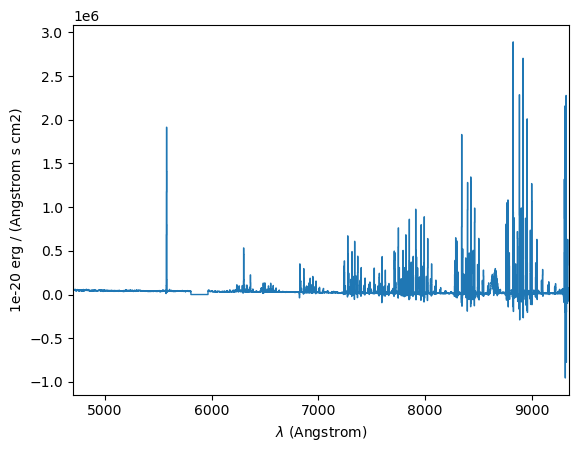

In [81]:
sp1 = cube.sum(axis=(1,2))

plt.figure()

sp1.plot()

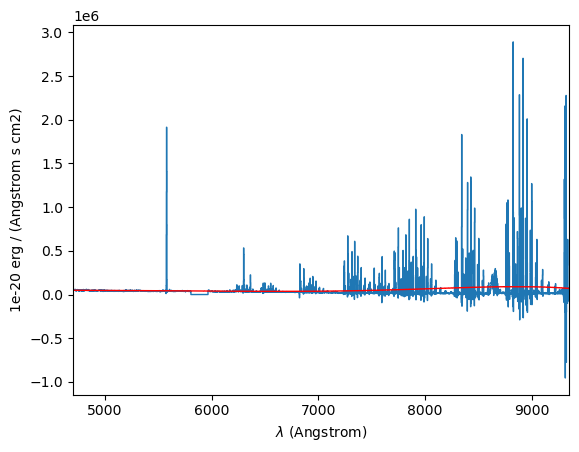

In [82]:
# Loop over all spectra to subtract background from spectra
plt.figure()
cont1 = sp1.poly_spec(5)
sp1.plot()
cont1.plot(color='r')

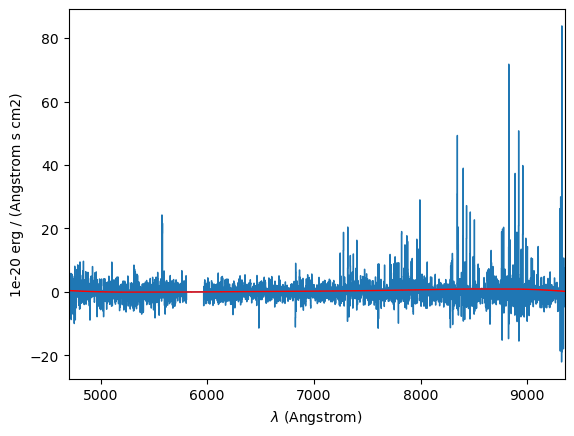

In [83]:
plt.figure()
sp1 = cube[:,100,100]
sp1.plot()
sp1.poly_spec(5).plot(color='r')

In [111]:
s = Source.from_data(ID=8621, ra=150.10522574429797, dec=2.313908771623179, origin=('test','v0.0','/Users/s2537809/MUSE/cube_26.fits', 'v1.34'))

In [112]:
s.info()


[INFO] ID      =                 8621 / object ID %d                                   
[INFO] RA      =   150.10522574429797 / RA u.degree %.7f                               
[INFO] DEC     =    2.313908771623179 / DEC u.degree %.7f                              
[INFO] FROM    = 'test    '           / detection software                             
[INFO] FROM_V  = 'v0.0    '           / version of the detection software              
[INFO] CUBE    = 'cube_26.fits'       / datacube                                       
[INFO] CUBE_V  = 'v1.34   '           / version of the datacube                        
[INFO] SRC_V   = ''                                                                    
[INFO] 0 spectra: 
[INFO] 0 images: 
[INFO] 0 cubes: 
[INFO] 0 tables: 


In [114]:

cube = Cube('/Users/s2537809/MUSE/cube_26.fits')
s.y, s.x = cube.wcs.sky2pix((s.dec,s.ra))[0]

In [115]:
s.info()


[INFO] ID      =                 8621 / object ID %d                                   
[INFO] RA      =   150.10522574429797 / RA u.degree %.7f                               
[INFO] DEC     =    2.313908771623179 / DEC u.degree %.7f                              
[INFO] FROM    = 'test    '           / detection software                             
[INFO] FROM_V  = 'v0.0    '           / version of the detection software              
[INFO] CUBE    = 'cube_26.fits'       / datacube                                       
[INFO] CUBE_V  = 'v1.34   '           / version of the datacube                        
[INFO] SRC_V   = ''                                                                    
[INFO] Y       =   219.78992154991693                                                  
[INFO] X       =   141.00382284764018                                                  
[INFO] 0 spectra: 
[INFO] 0 images: 
[INFO] 1 cubes: MUSE
[INFO] 0 tables: 


In [116]:
s.add_cube(cube, 'MUSE', size=5, lbda=(5000,8500))

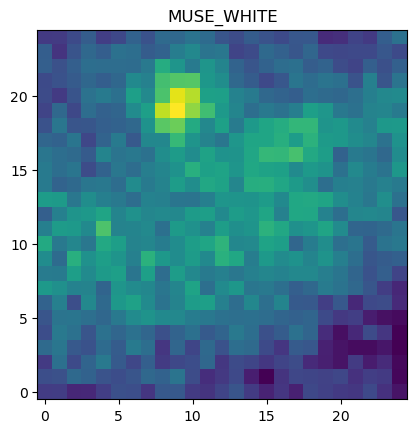

In [117]:
s.add_white_image(cube=cube, size=5)

s.images['MUSE_WHITE'].plot(title='MUSE_WHITE')

In [90]:
s.info()
s.write('source%04d.fits'%s.id)

[INFO] ID      =                 8621 / object ID %d                                   
[INFO] RA      =   150.09842635601223 / RA u.degree %.7f                               
[INFO] DEC     =   2.3092157537739473 / DEC u.degree %.7f                              
[INFO] FROM    = 'test    '           / detection software                             
[INFO] FROM_V  = 'v0.0    '           / version of the detection software              
[INFO] CUBE    = 'cube_26.fits'       / datacube                                       
[INFO] CUBE_V  = 'v1.34   '           / version of the datacube                        
[INFO] SRC_V   = ''                                                                    
[INFO] Y       =    135.3155396947909                                                  
[INFO] X       =   263.29317962712946                                                  
[INFO] 0 spectra: 
[INFO] 1 images: MUSE_WHITE
[INFO] 1 cubes: MUSE
[INFO] 0 tables: 


In [91]:
import numpy as np
from astropy import units as u
from mpdaf.obj import Cube, Image
from mpdaf.sdetect import compute_optimal_spectrum
from mpdaf.MUSE.PSF import MOFFAT1, create_psf_cube



def extract_spectra(self, cube, obj_mask='MASK_UNION', sky_mask='MASK_SKY',
                        tags_to_try=('MUSE_WHITE', 'NB_LYALPHA',
                                     'NB_HALPHA', 'NB_SUMOII3726'),
                        skysub=True, psf=None, beta=None, lbda=None,
                        apertures=None, unit_wave=u.angstrom):
        """Extract spectra from a data cube.

        This method extracts several spectra from a data cube and from a list
        of narrow-band images (to define spectrum extraction apertures).
        First, it computes a subcube that has the same size along the spatial
        axis as the mask image given by ``obj_mask``.

        Then, the no-weighting spectrum is computed as the sum of the subcube
        weighted by the mask of the object and saved in
        ``self.spectra['MUSE_TOT']``.

        The weighted spectra are computed as the sum of the subcube weighted by
        the corresponding narrow-band image. They are saved in
        ``self.spectra[nb_ima] for nb_ima in tags_to_try``.

        For the weighted spectra, with the psf and narrow-band images, the
        optimal extraction algorithm for CCD spectroscopy Horne, K. 1986 is
        used. See `mpdaf.sdetect.compute_optimal_spectrum` for more detail.

        If ``psf`` is True:
            The potential PSF weighted spectrum is computed as the sum of the
            subcube weighted by multiplication of the mask of the object and
            the PSF. It is saved in self.spectra['MUSE_PSF']

        If ``skysub`` is True:
            The local sky spectrum is computed as the average of the subcube
            weighted by the sky mask image.
            It is saved in ``self.spectra['MUSE_SKY']``

            The other spectra are computed on the sky-subtracted subcube and
            they are saved in ``self.spectra['*_SKYSUB']``.

        Parameters
        ----------
        cube : `~mpdaf.obj.Cube`
            Input data cube.
        obj_mask : str
            Name of the image that contains the mask of the object.
        sky_mask : str
            Name of the sky mask image.
        tags_to_try : list of str
            List of narrow-band images.
        skysub : bool
            If True, a local sky subtraction is done.
        psf : numpy.ndarray
            The PSF to use for PSF-weighted extraction.  This can be a vector
            of length equal to the wavelength axis to give the FWHM of the
            Gaussian or Moffat PSF at each wavelength (in arcsec) or a cube
            with the PSF to use. No PSF-weighted extraction by default.
        beta : float or none
            If not none, the PSF is a Moffat function with beta value,
            else it is a Gaussian.
        lbda : (float, float) or none
            If not none, tuple giving the wavelength range.
        unit_wave : `astropy.units.Unit`
            Wavelengths unit (angstrom by default)
            If None, inputs are in pixels
        apertures : list of float
            List of aperture radii (arcseconds) for which a spectrum is
            extracted.

        """
        if obj_mask not in self.images:
            raise ValueError('key %s not present in the images dictionary'
                             % obj_mask)

        if skysub and sky_mask not in self.images:
            raise ValueError('key %s not present in the images dictionary'
                             % sky_mask)

        ima = self.images[obj_mask]

        if ima.wcs.sameStep(cube.wcs):
            size = ima.shape[0]
            unit_size = None
        else:
            size = ima.wcs.get_step(unit=u.arcsec)[0] * ima.shape[0]
            unit_size = u.arcsec

        center = (self.dec, self.ra)
        subcub = cube.subcube(center=center, size=size,
                              unit_center=u.deg, unit_size=unit_size,
                              lbda=lbda, unit_wave=unit_wave)
        wcsref = subcub.wcs

        if not ima.wcs.isEqual(wcsref):
            ima = ima.resample(
                newdim=subcub.shape[1:],
                newstart=wcsref.get_start(unit=u.deg),
                newstep=wcsref.get_step(unit=u.arcsec),
                order=0, unit_start=u.deg, unit_step=u.arcsec)

        object_mask = ima.data.data

        if skysub:
            skymask = self.images[sky_mask]
            if not skymask.wcs.isEqual(wcsref):
                skymask = skymask.resample(
                    newdim=subcub.shape[1:],
                    newstart=wcsref.get_start(unit=u.deg),
                    newstep=wcsref.get_step(unit=u.arcsec),
                    order=0, unit_start=u.deg, unit_step=u.arcsec)

            # Get the sky spectrum and subtract it
            self.spectra['MUSE_SKY'] = subcub.mean(weights=skymask.data.data,
                                                   axis=(1, 2))
            subcub = subcub - self.spectra['MUSE_SKY']
            suffix = '_SKYSUB'
        else:
            suffix = ''

        # No weighting
        spec = (subcub * object_mask).sum(axis=(1, 2))
        self.spectra['MUSE_TOT' + suffix] = spec

        if apertures:
            tmpim = Image(data=np.zeros_like(object_mask, dtype=bool),
                          copy=False, wcs=ima.wcs)
            for radius in apertures:
                tmpim.mask_ellipse(center, radius, 0)
                mask = object_mask.astype(bool) & tmpim.mask
                # spec = compute_spectrum(subcub, weights=mask)
                spec = (subcub * mask).sum(axis=(1, 2))
                self.spectra['MUSE_APER_%.1f%s' % (radius, suffix)] = spec
                tmpim.unmask()

        
       

            # Insert the PSF weighted flux - here re-normalised?

        

# Extract the spectra from the cube
spec = extract_spectra(s, cube, obj_mask='MUSE_WHITE', tags_to_try=['MUSE_WHITE'], skysub=True, beta=None, lbda=None, apertures=None, unit_wave=u.angstrom)

print(spec)

ValueError: key MASK_SKY not present in the images dictionary

In [92]:

# Add seg images
s.add_seg_images()

# Print available segmentation tags
print(s.images.keys())


# Add seg tags 
seg_tags = ['MUSE_WHITE', 'SEG_MUSE_WHITE']

# Find sky mask 
sky_mask = s.find_sky_mask(seg_tags)

# Find the union mask from segmentation tags
union_mask = s.find_union_mask(seg_tags)
print("Union Mask type:", type(union_mask))  # Debugging step


# Find the intersection mask from segmentation tags
intersection_mask = s.find_intersection_mask(seg_tags)


# Assuming `cube` is your MUSE data cube and is available
# Compute the spectra using the union mask
spectrum_union = s.extract_spectra(cube,'UNION_MASK')

# Compute the spectra using the intersection mask
#spectrum_intersection = s.extract_spectra(cube, intersection_mask)

# Print or use the computed spectra as needed
#print("Spectrum using union mask:", spectrum_union)
#print("Spectrum using intersection mask:", spectrum_intersection)


> 
----- SExtractor 2.28.0 started on 2024-08-19 at 11:59:34 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for 8621-MUSE_WHITE.fits
----- Measuring from: 8621-MUSE_WHITE.fits [1/1]
      "MUSE-JELS - Pointing" / no ext. header / 25x25 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 0.669307   RMS: 0.324319   / Threshold: 0.24324    
> Scanning image
> Line:   25  Objects:        2 detected /        0 sextracted
> Line:   25  Objects:        2 detected /        2 sextracted
      Objects: detected 2        / sextracted 2               

> Closing files
> 
> All done (in 0.0 s: 1672.1 lines/s , 133.8 detections/s)
[DEBUG] Doing MUSE_WHITE
[DEBUG] Image MUSE_WHITE has one useful objects
[DEBUG] Doing M

SExtractor version 2.28.0 (2023-03-11)
KeysView(2 images: MUSE_WHITE SEG_MUSE_WHITE)
Union Mask type: <class 'NoneType'>


ValueError: key UNION_MASK not present in the images dictionary

In [25]:

# Print available segmentation tags
print(s.images.keys())

KeysView(2 images: MUSE_WHITE SEG_MUSE_WHITE)


In [16]:
import os
import subprocess

# Add the directory containing 'sex' to the PATH
os.environ['PATH'] += ':/opt/homebrew/bin'

# Verify that SExtractor can be found
try:
    subprocess.check_call(['sex', '-v'])
    print("SExtractor is available and working.")
except FileNotFoundError:
    print("SExtractor could not be found.")



SExtractor version 2.28.0 (2023-03-11)
SExtractor is available and working.


In [15]:
from mpdaf.obj import Cube

# Load the MUSE data cube
cube = Cube('/Users/s2537809/MUSE/cube_26.fits')



In [26]:
from mpdaf.obj import Cube
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt

# Load the MUSE data cube
cube = Cube('/Users/s2537809/MUSE/cube_26.fits')

# Source coordinates (RA, DEC) in degrees
ra = 150.0  # in degrees
dec = 2.0   # in degrees
source_coord = SkyCoord(ra, dec, unit=(u.deg, u.deg))

# Convert the source coordinates (RA, DEC) to pixel coordinates in the cube
pix_coords = cube.wcs.sky2pix([[source_coord.ra.deg, source_coord.dec.deg]])[0]
x_pix, y_pix = pix_coords

# Define the circular aperture radius in arcseconds
aperture_radius_arcsec = 0.6  # in arcseconds

# Get pixel scale in arcseconds/pixel from CDELT1 (assuming square pixels)
pixel_scale_deg = abs(cube.wcs.wcs.cdelt[0])  # degrees per pixel
pixel_scale_arcsec = pixel_scale_deg * 3600   # convert to arcseconds/pixel

# Convert aperture radius from arcseconds to pixels
aperture_radius_pix = aperture_radius_arcsec / pixel_scale_arcsec

# Extract the spectrum within the circular aperture
spectrum = cube.aperture((x_pix, y_pix), aperture_radius_pix)

# Plot the extracted spectrum
plt.plot(spectrum.wave.coord(), spectrum.data)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux [erg/s/cm²/Å]')
plt.title(f'Spectrum for RA={ra}, DEC={dec} (Aperture Radius={aperture_radius_arcsec} arcsec)')
plt.show()

# Optionally, save the spectrum to a file
spectrum.write('extracted_spectrum.fits')




AttributeError: 'WCS' object has no attribute 'cdelt'

In [31]:
# Path to the MUSE data cube
cube_file = '/Users/s2537809/MUSE/cube_26.fits'


# Load the MUSE data cube
cube = Cube(cube_file)





# RA and Dec of the source (in degrees)
ra = 150.09889815269983  
dec = 2.309368063400143

# Create a SkyCoord object for the source position
source_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

print(f"RA: {source_coord.ra.deg}, Dec: {source_coord.dec.deg}")

# Convert the RA/Dec to pixel coordinates in the cube
#pix_coords = cube.wcs.wcs_world2pix([[source_coord.ra.deg, source_coord.dec.deg]], 0)[0]
x_pix, y_pix = int(pix_coords[0]), int(pix_coords[1])

# Define the radius for the aperture (0.6 arcseconds)
aperture_radius = 0.6 / cube.get_step()[0]  # Convert to pixel units

# Extract the 1D spectrum using the circular aperture
spectrum = cube.get_spec(cube.aperture((x_pix, y_pix), aperture_radius))

# Plot the spectrum (optional)
spectrum.plot()

# Save the spectrum to a file (optional)
#spectrum.write('outputs/extracted_spectrum.fits')

# Alternatively, print the spectrum data
print(spectrum.data)

RA: 150.09889815269983, Dec: 2.309368063400143


AttributeError: 'Cube' object has no attribute 'get_spec'

In [73]:
class SpectrumExtractor:
    def __init__(self, images, dec, ra):
        self.images = images
        self.dec = dec
        self.ra = ra
        self.spectra = {}

def extract_spectras(self, cube, obj_mask='MASK_UNION', sky_mask='MASK_SKY',
                    tags_to_try=('MUSE_WHITE', 'NB_LYALPHA',
                                 'NB_HALPHA', 'NB_SUMOII3726'),
                    skysub=True, psf=None, beta=None, lbda=None,
                    apertures=None, unit_wave=u.angstrom):
    """Extract spectra from a data cube and normalize it by the PSF using a specific aperture."""
    
    if obj_mask not in self.images:
        raise ValueError(f'Key {obj_mask} not present in the images dictionary')

    if skysub and sky_mask not in self.images:
        raise ValueError(f'Key {sky_mask} not present in the images dictionary')

    ima = self.images[obj_mask]

    if ima.wcs.sameStep(cube.wcs):
        size = ima.shape[0]
        unit_size = None
    else:
        size = ima.wcs.get_step(unit=u.arcsec)[0] * ima.shape[0]
        unit_size = u.arcsec

    center = (self.dec, self.ra)
    subcub = cube.subcube(center=center, size=size,
                          unit_center=u.deg, unit_size=unit_size,
                          lbda=lbda, unit_wave=unit_wave)
    wcsref = subcub.wcs

    if not ima.wcs.isEqual(wcsref):
        ima = ima.resample(
            newdim=subcub.shape[1:],
            newstart=wcsref.get_start(unit=u.deg),
            newstep=wcsref.get_step(unit=u.arcsec),
            order=0, unit_start=u.deg, unit_step=u.arcsec)

    object_mask = ima.data.data

    if skysub:
        skymask = self.images[sky_mask]
        if not skymask.wcs.isEqual(wcsref):
            skymask = skymask.resample(
                newdim=subcub.shape[1:],
                newstart=wcsref.get_start(unit=u.deg),
                newstep=wcsref.get_step(unit=u.arcsec),
                order=0, unit_start=u.deg, unit_step=u.arcsec)

        # Get the sky spectrum and subtract it
        self.spectra['MUSE_SKY'] = subcub.mean(weights=skymask.data.data, axis=(1, 2))
        subcub = subcub - self.spectra['MUSE_SKY']
        suffix = '_SKYSUB'
    else:
        suffix = ''

    # No weighting
    spec = (subcub * object_mask).sum(axis=(1, 2))
    self.spectra['MUSE_TOT' + suffix] = spec

    # 0.6 arcsecond aperture extraction
    if apertures:
        tmpim = Image(data=np.zeros_like(object_mask, dtype=bool),
                      copy=False, wcs=ima.wcs)
        for radius in apertures:
            tmpim.mask_ellipse(center, radius, 0)
            mask = object_mask.astype(bool) & tmpim.mask
            spec = (subcub * mask).sum(axis=(1, 2))
            self.spectra['MUSE_APER_%.1f%s' % (radius, suffix)] = spec
            tmpim.unmask()

    # PSF normalization
    if psf is not None:
        if len(psf.shape) == 3:
            if not np.array_equal(psf.shape, subcub.shape):
                raise ValueError('Incorrect dimensions for the PSF cube '
                                 f'({psf.shape}) (it must be ({subcub.shape}))')
        elif len(psf.shape) == 1:
            psf = create_psf_cube(subcub.shape, psf, beta=beta, wcs=wcsref)

        # Extract spectrum using the PSF and normalize it
        spec_psf = compute_optimal_spectrum(subcub, object_mask, psf)
        self.spectra['MUSE_PSF' + suffix] = spec_psf / spec_psf.max()  # Normalized

        # Return the spectrum for plotting
        return spec_psf / spec_psf.max()


In [72]:
# Add segmentation images
s.add_seg_images()

# Print available segmentation tags
print(s.images.keys())

# Segmentation tags
seg_tags = ['MUSE_WHITE', 'SEG_MUSE_WHITE']

# Find the sky mask and union mask
sky_mask = s.find_sky_mask(seg_tags)
union_mask = s.find_union_mask(seg_tags)

# If union_mask is not a key, assign it to a key
s.images['UNION_MASK'] = union_mask

# Define PSF and other parameters
psf = np.random.rand(cube.shape[0], 50, 50).astype(np.float64)  # Example PSF
psf /= np.sum(psf, axis=(1, 2))[:, np.newaxis, np.newaxis]  # Normalize PSF

# Extract the spectrum with a 0.6 arcsecond aperture and normalized by the PSF
spectrum_psf = extract_spectras(cube=cube, obj_mask='UNION_MASK', sky_mask=sky_mask,
                                 apertures=[0.6], psf=psf)

# Plot the extracted spectrum
plt.figure(figsize=(10, 6))
plt.plot(cube.wave.coord(), spectrum_psf, label='PSF Normalized Spectrum')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux')
plt.title('Extracted Spectrum with PSF Normalization (0.6 arcsec aperture)')
plt.legend()
plt.show()



> 
----- SExtractor 2.28.0 started on 2024-08-19 at 11:07:53 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for 8621-MUSE_WHITE.fits
----- Measuring from: 8621-MUSE_WHITE.fits [1/1]
      "Unnamed" / no ext. header / 25x25 / 8 bits (integers)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 0.00572298 RMS: 0.479928   / Threshold: 0.359946   
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   25  Objects:        1 detected /        1 sextracted
      Objects: detected 1        / sextracted 1               

> Closing files
> 
> All done (in 0.0 s: 1559.8 lines/s , 62.4 detections/s)
[DEBUG] Doing MUSE_WHITE
[DEBUG] Image MUSE_WHITE has one useful objects


SExtractor version 2.28.0 (2023-03-11)
KeysView(6 images: MUSE_WHITE SEG_MUSE_WHITE MASK_SKY MASK_UNION MASK_INTER UNION_MASK)


TypeError: extract_spectras() missing 1 required positional argument: 'self'

In [ ]:
yy, xx = np.indices([5,5], dtype='float')  
radius = ((yy-2)**2 + (xx-2)**2)**0.5  
mask = radius <= 2  
subcube = cube[:, 50:55, 60:65]  
maskedsubcube = subcube.with_mask(mask)  
spectrum = maskedsubcube.mean(axis=(1,2))  

In [108]:
from astropy.table import Table

# Define the file path
file_path = '/Users/s2537809/Downloads/Photom+Photoz_PRIMER_COSMOS_f356w_v0p8_WithAuto.cat'

# Load the catalog
cat = Table.read(file_path, format='ascii')

# Display the first few rows of the table


print(len(cat))


z6_cat = cat[(cat['zmed_all'] >= 5.5) &(cat['zmed_all'] <= 6.5)]

print(len(z6_cat))

94593
4110


In [106]:
cat

id,x,y,ra,dec,f435w,f435w_err,f606w,f606w_err,f814w,f814w_err,f090w,f090w_err,f115w,f115w_err,f150w,f150w_err,f200w,f200w_err,f277w,f277w_err,f356w,f356w_err,f410m,f410m_err,f444w,f444w_err,zmed_all,chimed_all,chimed_pegase,zmed_pegase,zphot_bc03,chisq_bc03,zphot_pegase,chisq_pegase,zphot_mod3,chisq_mod3,zphot_mod4,chisq_mod4,zphot_pca,chisq_pca,flux_auto_f356w
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
79,10892.4932,941.7943,150.14383199,2.1550667928,-99.0,-99.0,0.002923280848983582,0.0031114396683831224,0.002245138926102567,0.0038221158059218714,-0.006962759161528312,0.006307985966705138,-0.004866710618005929,0.0033526607169740625,-0.007285601910477345,0.0049240174426023135,-0.002221014807461637,0.0028340961982184546,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.32269999384880066,8.826169967651367,8.826169967651367,0.32280001044273376,0.3227,9.59106,0.3228,9.04645,0.3228,8.82617,6.7402,6.61706,0.07188525795936584,7.345889091491699,-0.007439024
83,10967.9697,944.0066,150.14320258,2.1550852355,-99.0,-99.0,0.002957230007740253,0.003402115867460064,0.001707960117357055,0.003408241568619228,-0.01979742319394706,0.00989871159697353,-0.0077793867080219155,0.005075885736000007,0.008494220737213017,0.005475741714981744,0.003934809943334574,0.004143318364901475,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,9.858200073242188,7.577630043029785,7.591720104217529,9.733400344848633,9.8582,7.57763,9.7334,7.58363,9.7327,7.59172,9.9385,7.65329,9.912951469421387,-1.0,0.002386521
94,10956.6885,945.4484,150.14329665,2.1550972494,-99.0,-99.0,0.003735161119485069,0.0033650633572224844,2.0506517603558223e-05,0.0034581402621587528,-0.010475292145722825,0.008163236285147474,0.007770121742932488,0.004959355664040454,-0.007473021389638276,0.00559374964046742,0.00803919841171361,0.003970979209547634,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3.627000093460083,7.226830005645752,7.226830005645752,3.627000093460083,2.3435,7.25284,3.627,7.27581,2.3451,7.22683,12.0,7.13595,7.4087300300598145,6.850575923919678,-0.004165671
106,10982.1592,950.4786,150.14308425,2.1551391698,-99.0,-99.0,0.002526885159082576,0.0032818273955949736,0.005549283599485558,0.0033413725985927518,0.022816244379223995,0.008036467367744597,0.021338277289682593,0.005371181107037979,-0.01440755244177724,0.00720377622088862,0.0008524808702485832,0.004071389179718363,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.8859000205993652,15.812299728393555,15.812299728393555,0.8845999836921692,0.8859,16.5197,0.8846,15.8123,0.8845,15.4717,0.8861,17.2064,1.5371423959732056,13.415436744689941,-0.00915495
110,10906.7256,966.6401,150.14371331,2.1552738402,-99.0,-99.0,-0.0012873273719802825,0.003010098287654198,0.005975115883393173,0.003971562973677259,0.0001999220832547995,0.007181729274637908,0.00399037158238485,0.004818586109988942,0.00823803646148764,0.005481228493373029,-0.001784846134756173,0.0035048808510034627,0.24076013513513517,0.012038006756756758,0.31795298501214103,0.015897649250607052,0.7980361889184215,0.03990180944592108,0.238130509354799,0.011906525467739952,4.9944000244140625,323.3160095214844,330.6239929199219,4.9944000244140625,4.9982,323.316,4.9891,338.089,4.9944,330.624,5.4102,325.453,-1.0,-1.0,0.3171658
113,11002.0039,963.9799,150.14291877,2.1552516813,-99.0,-99.0,-0.0008130155416140464,0.0032457951020367195,-0.005199984593537324,0.0034657544594620423,0.002742364832117181,0.008015143017079267,-0.0004424389235793242,0.005562448071726006,0.007113654820238948,0.006496320201792409,0.0004934370476072299,0.0037299162984426423,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,9.823200225830078,3.0952000617980957,3.1017799377441406,9.571200370788574,9.8232,3.0952,9.5712,3.09634,9.57,3.10178,9.93

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Spectrum, Cube

cube_no = '26'
match = 'Primer (extra z cut)'

# Specify the coordinates of the source (in RA and Dec)
ra_center = 150.10522574429797  # Replace with the actual RA in degrees
dec_center = 2.313908771623179  # Replace with the actual Dec in degrees
cat2_label = '33'

# Specify the aperture radius (in arcseconds)
aperture_radius_arcsec = 0.6 

# Load the MUSE data cube using mpdaf
filename = f'/Users/s2537809/MUSE/cube_{cube_no}.fits'
cube = Cube(filename)

with fits.open(filename) as hdulist:
    header = hdulist[0].header

# Extract WCS information
im_wcs = WCS(header)

# Use the middle wavelength value of the cube for the 3rd dimension
wavelength_center = cube.wave.coord()

# Convert RA, Dec, and wavelength to pixel coordinates
pixel_coords = im_wcs.wcs_world2pix(ra_center, dec_center, wavelength_center, 0)

x_center = int(pixel_coords[0][0])
y_center = int(pixel_coords[1][0])